# Na Analysis - run 2948 - 19/11/2016 - NaI tag
# Xrays from panda

Notebook to analysis of wfs of Na run 2948 (161119) tag with NaI

* read the panda
* study x-rays
  * drift attatchment, xy-distribution
* study energy resolution

Author: J.A. Hernando

Version: v00

In [1]:
from __future__ import print_function
import cProfile
import pandas as pd
import tables as tb
import numpy as np
import time

import Core.fitFunctions as fitf
import Calib.calib as cb
import Database.loadDB as db

import xrayFunctions as xrayf
import xrayPlots as xrayplt

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 6) # Bigger plots

%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Run {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

Run 15/12/2016 at 20:24:36.


## Opts

In [2]:
idatapath = 'data/'
ifilename = 'r2948_tam_s1trg'
ifile = idatapath+ifilename

tscale = 0.025

## Input data

In [3]:
print('input file ', ifile)
pan = pd.read_csv(ifile+'.csv')
print('entries ', len(pan))
xs = pan['x']
ys = pan['y']
pan['r'] = np.sqrt(xs*xs+ys*ys)
pan['dt'] = pan['t']-pan['t0']

input file  data/r2948_tam_s1trg
entries  12334


### Selecting the x-rays

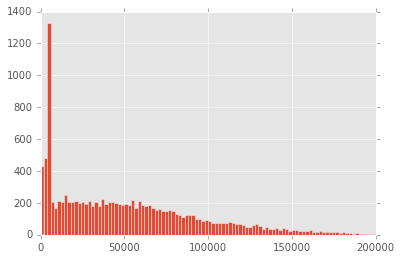

In [4]:
plt.hist(pan['tcat'], bins=100, range=(0., 2.e5));

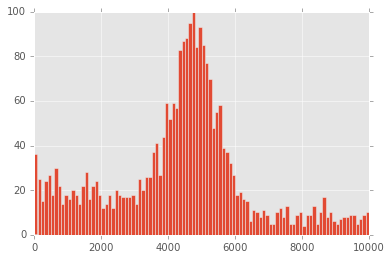

In [5]:
plt.hist(pan['tcat'], bins=100, range=(0., 1.e4));

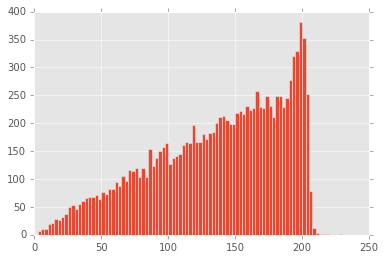

In [6]:
plt.hist(pan['r'], bins=100, range=(0., 250.));

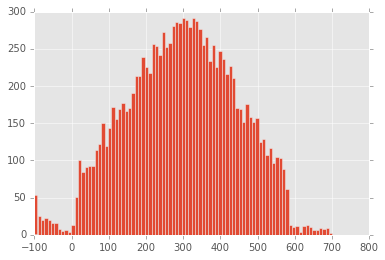

In [7]:
plt.hist(tscale*pan['dt'], bins=100, range=(-100., 800.));

### preliminary selection

In [48]:
xsel = (pan['tcat'] > 2.5e3) & (pan['tcat'] < 7.5e3)
rsel = pan['r'] < 180.
tsel = (tscale*pan['dt'] > 10.) & (tscale*pan['dt'] < 550.)
sel = xsel & rsel & tsel

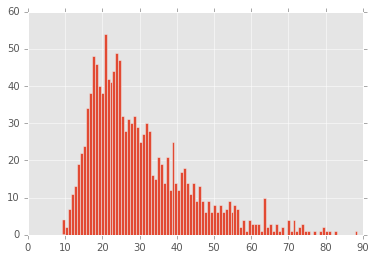

In [49]:
fig, ax = plt.subplots()
ax.hist(pan['t0icat'][sel], bins=100);

(0.0, 550.0)

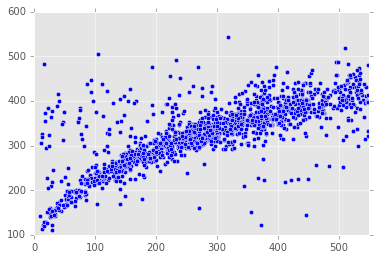

In [50]:
fig, ax = plt.subplots()
ax.scatter(tscale*pan['dt'][sel], pan['twd'][sel])
ax.set_ylim(100., 600.)
ax.set_xlim(0., 550.)

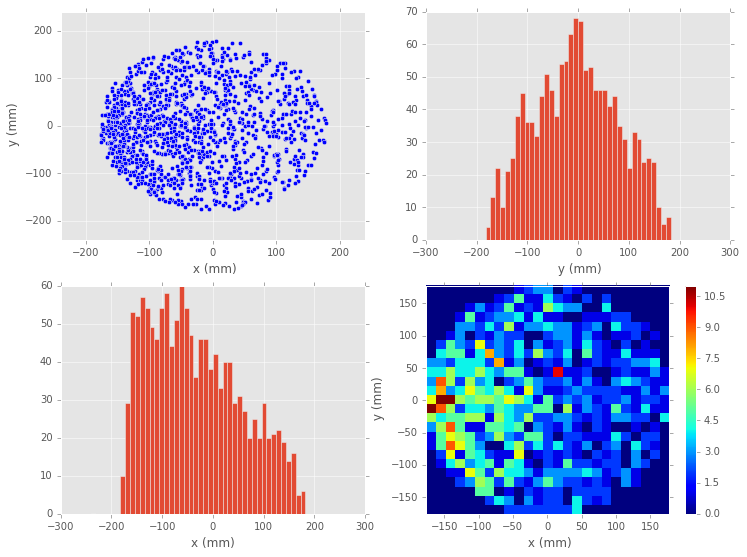

In [51]:
fig = xrayplt.plot_xybarycenter(pan[sel], bins=50)

### secondary selection

In [52]:
wsel1 = pan['twd'] < (6.+9*tscale*pan['dt']/600.)/tscale
wsel2 = pan['twd'] > (9*pan['dt']*tscale/600.)/tscale
wsel = wsel1 & wsel2
sel = sel & wsel

(0.0, 550.0)

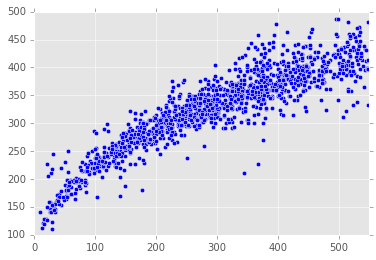

In [53]:
fig, ax = plt.subplots()
ax.scatter(tscale*pan['dt'][sel], pan['twd'][sel])
ax.set_ylim(100., 500.)
ax.set_xlim(0., 550.)

## Selection 

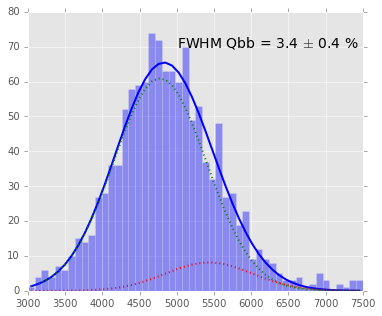

In [54]:
enes = pan['tcat'][sel]
# result = xrayf.energy_resolution(enes, range=(3000., 7500.))
fig, cc = xrayplt.plot_energy_resolution(enes, bins=50, range=(3000., 7500.), 
                                         textpos=(5000., 70.))
# fig.savefig('imgcc/'+ifile+'_ene_res_raw.png')

('mu = ', (-1.5941825360193045, 0.22894518414753909))
('tau = ', (3.3356385327592246, 0.48103222050039773))


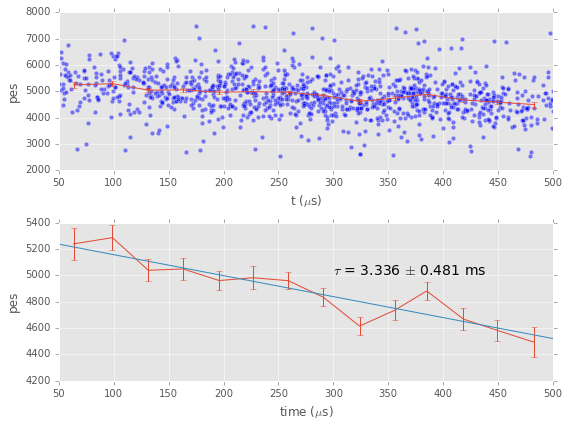

In [98]:
times = tscale*pan['dt'][sel]
enes = pan['tcat'][sel]
# cc = xrayf.attachment(times, enes, bins=10, range=(50., 550.))
fig, cc = xrayplt.plot_attachment(times, enes, bins=15, range=(50., 500.), 
                                  textpos=(300., 5000.)) 

In [99]:
mu = cc[-2][0]
print(mu)
enes1 = enes-times*mu

-1.59418253602


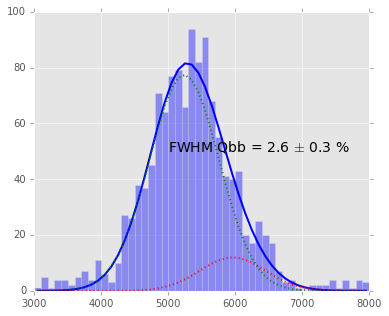

In [100]:
fig, cc = xrayplt.plot_energy_resolution(enes1, bins=50, range=(3000., 8000), 
                                         textpos=(5000., 50.))

(' radius - fit result ', array([  5.72855247e+03,   4.16855599e-01,  -2.83328644e-02]))
(' fit result ', array([  5.72855247e+03,   4.16855599e-01,  -2.83328644e-02]))


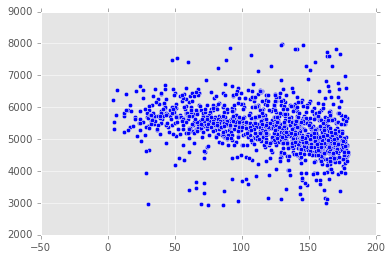

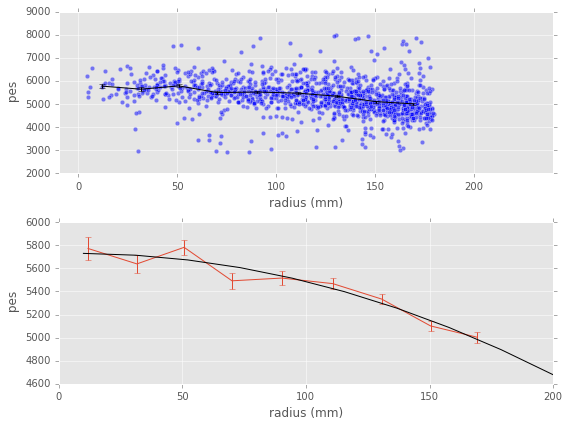

In [101]:
rads = pan['r'][sel]
plt.scatter(rads, enes1)
fig, cc = xrayplt.plot_radius_correction(rads, enes1, bins=10, range=(0., 180.))
# fig.savefig('imgcc/'+ifile+'_ene_vs_radius.png')

In [103]:
result = cc[0]
mrad, srad = result.x[1], result.x[2]
enes2 = enes1-mrad*rads-srad*rads*rads

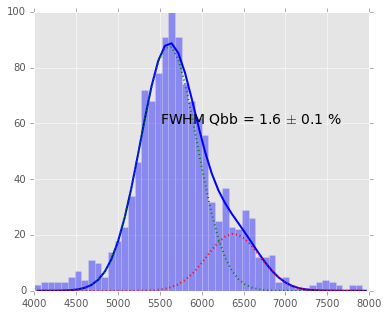

In [105]:
fig, res = xrayplt.plot_energy_resolution(enes2, bins=50, range=(4000., 8000.), 
                                          textpos=(5500., 60.))

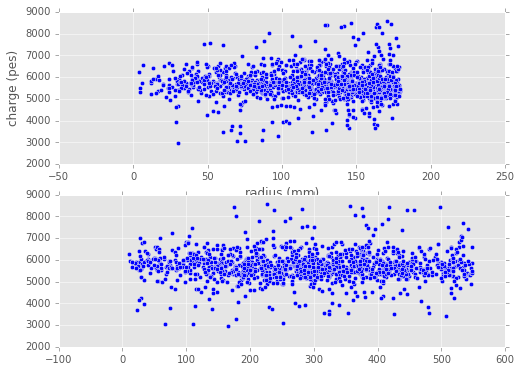

In [106]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].scatter(rads, enes2)
axs[0].set_xlim(-50., 250)
axs[0].set_xlabel('radius (mm)')
axs[0].set_ylabel('charge (pes)')
axs[1].scatter(times, enes2)
# fig.savefig('imgcc/'+ifile+'_correne_vs_radius.png')

In [107]:
pan['ene'] = pan['tcat']-mu*pan['dt']*tscale-mrad*pan['r']-srad*pan['r']*pan['r']

In [108]:
r1sel = pan['r'] < 130.
r2sel = pan['r'] >= 130.

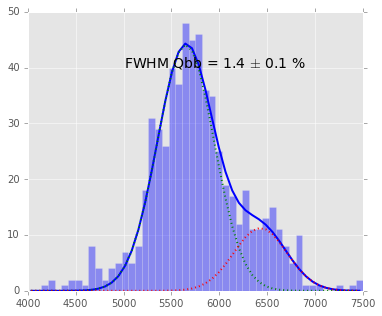

In [116]:
rene1 = pan['ene'][sel & r1sel]
rene2 = pan['ene'][sel & r2sel]
fig, cc = xrayplt.plot_energy_resolution(rene1, bins=50, range=(4000., 7500.), 
                                         textpos=(5000., 40.))
# fig.savefig('imgcc/'+ifile+'_correne_radle12.png')

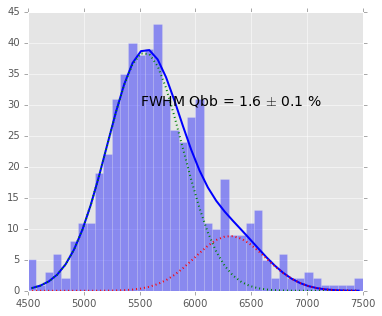

In [115]:
rene2 = pan['ene'][sel & r2sel]
fig, res = xrayplt.plot_energy_resolution(rene2, bins=40, range=(4500., 7500.), 
                                          textpos=(5500., 30.))
# fig.savefig('imgcc/'+ifile+'_correne_radgt12.png')

## Correlations

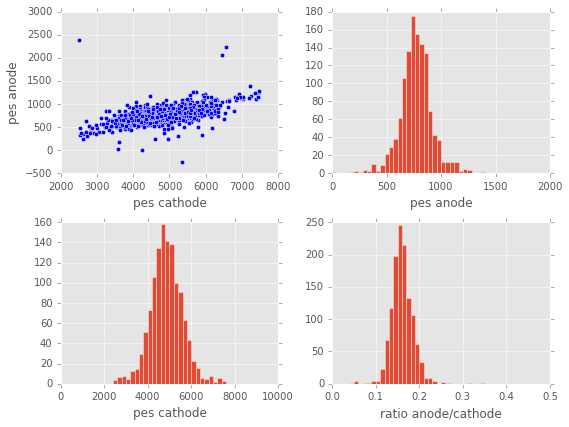

In [117]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0][0].scatter(pan['tcat'][sel], pan['tano'][sel])
axs[0][0].set_xlabel('pes cathode')
axs[0][0].set_ylabel('pes anode')
axs[1][0].hist(pan['tcat'][sel], bins=50, range=(0., 10000.))
axs[1][0].set_xlabel('pes cathode')
axs[0][1].hist(pan['tano'][sel], bins=50, range=(0., 2000.))
axs[0][1].set_xlabel('pes anode')
isel = sel & (pan['tcat'] > 10.)
axs[1][1].hist(pan['tano'][isel]/pan['tcat'][isel], bins=50, range=(0., .5));
axs[1][1].set_xlabel('ratio anode/cathode')
fig.tight_layout()
# fig.savefig('img/'+ifile+'_charge_corr_catano.png')

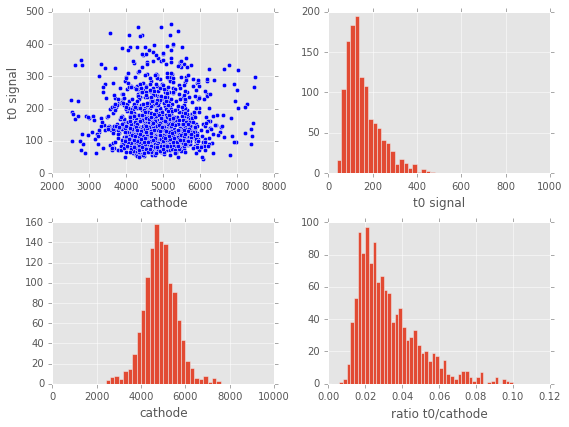

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0][0].scatter(pan['tcat'][sel], pan['t0cat'][sel])
axs[0][0].set_xlabel('cathode')
axs[0][0].set_ylabel('t0 signal')
axs[1][0].hist(pan['tcat'][sel], bins=50, range=(0., 10000.))
axs[1][0].set_xlabel('cathode')
axs[0][1].hist(pan['t0cat'][sel], bins=50, range=(0., 1000.))
axs[0][1].set_xlabel('t0 signal')
isel = sel & (pan['tcat'] > 10.)
axs[1][1].hist(pan['t0cat'][isel]/pan['tcat'][isel], bins=50., range=(0., 0.1));
axs[1][1].set_xlabel('ratio t0/cathode')
fig.tight_layout()
# fig.savefig('img/'+ifile+'_charge_corr_s1s2.png')

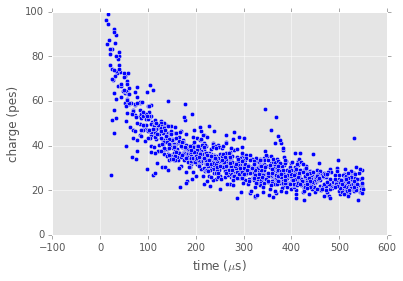

In [121]:
fig, ax = plt.subplots()
ax.scatter(tscale*pan['dt'][sel], pan['ticat'][sel]);
ax.set_xlabel(u'time ($\mu$s)')
ax.set_ylabel(u'charge (pes)')
ax.set_ylim((0., 100.));
# fig.savefig('img/'+ifile+'_width_vs_dt.png')

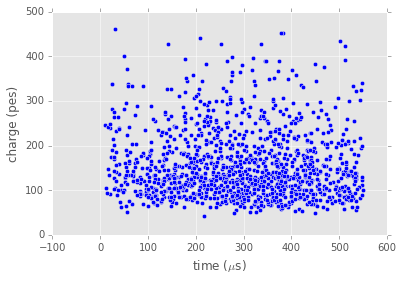

In [122]:
fig, ax = plt.subplots()
ax.scatter(tscale*pan['dt'][sel], pan['t0cat'][sel]);
ax.set_xlabel(u'time ($\mu$s)')
ax.set_ylabel(u'charge (pes)')
ax.set_ylim((0., 500.));
# fig.savefig('img/'+ifile+'_width_vs_dt.png')

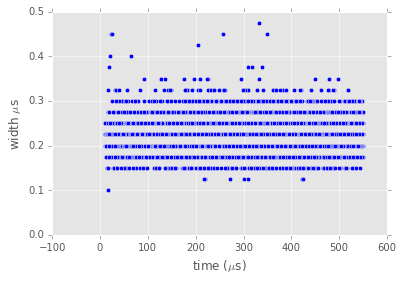

In [123]:
fig, ax = plt.subplots()
ax.scatter(tscale*pan['dt'][tsel], tscale*pan['t0wd'][tsel]);
ax.set_ylim((0., 0.5))
ax.set_xlabel(u'time ($\mu$s)')
ax.set_ylabel(u'width $\mu$s');